## Importing libraries and Dataset

In [1]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot as plt
from torch.optim import Adam
from Phytopredictor import PhytoPredictor, aggregate_phyto_data, extrapolate, train_phytopredictor
from NaivePredictor import NaivePredictor

In [2]:
df = pd.read_excel('../../data/MERGED_DATA_INTERPOLATED_DEF.xlsx', sheet_name='MERGE')
df.head()

,LOC_CODE,DATUM,TIJD,ZS [mg/l],ZICHT [dm],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],...,Pde,Plo,Dpu,Rte,Fja,Hak,Mhe,Dno,Dat,interpolated_columns
0,DANTZGT,1990-01-10,15:00:00,135.0,2.0,4.0,20.178571,29.19,1.645161,7.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
1,DANTZGT,1990-02-06,13:40:00,295.0,0.5,6.0,19.803571,27.37,1.177419,7.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"['SiO2 [umol/L]', 'PO4 [umol/L]', 'pH [DIMSLS]..."
2,DANTZGT,1990-03-08,13:45:00,103.0,3.0,7.3,19.428571,24.99,0.709677,8.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
3,DANTZGT,1990-04-04,10:00:00,113.0,3.0,8.2,6.285714,28.79,0.806452,8.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]
4,DANTZGT,1990-05-09,15:30:00,20.0,11.0,17.4,1.714286,33.28,1.161290,8.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,[]


## Defining the different columns and preparing the dataframe

In [3]:

columns = list(df.columns)

abio_columns = ['ZS [mg/l]', 'T [oC]', 'SiO2 [umol/L]', 'SALNTT [DIMSLS]', 'PO4 [umol/L]', 'pH [DIMSLS]', 'NO3 [umol/L]', 'NO2 [umol/L]', 'NH4 [umol/L]', 'E [/m]', 'CHLFa [ug/l]']
phyto_columns = ['Acn', 'Aco', 'Agl', 'Ata', 'Cau', 'Ccu', 'Cda',
       'Cdeb', 'Cden', 'Cdi', 'Cei', 'Cfu', 'Cgr', 'Cha', 'Coc', 'Cra', 'Csu',
       'Cwa', 'Dac', 'Dat', 'Dbr', 'Dip', 'Dle', 'Dno', 'Dpu', 'Dro', 'Dsp',
       'Edu', 'Etr', 'Ezo', 'Fja', 'Gde', 'Gfa', 'Gfl', 'Gsp', 'Hak', 'Hta',
       'Kgl', 'Lan', 'Lun', 'Mhe', 'Mnu', 'Mpe', 'Ndi', 'Nsc', 'Nsi', 'Oau',
       'Omo', 'Ore', 'Orh', 'Oro', 'Osi', 'Pac', 'Pan', 'Pba', 'Pbi', 'Pbr',
       'Pcl', 'Pco', 'Pde', 'Pha', 'Plo', 'Pmi', 'Pos', 'Pse', 'Pst', 'Psu',
       'Pte', 'Ptr', 'Ram', 'Rse', 'Rst', 'Rte', 'Stu', 'Tec', 'Tle', 'Tni',
       'Tno', 'Tor', 'Tro']
loc_date_columns = ["LOC_CODE", "DATUM"]

ignored_columns = set(df.columns) - set(loc_date_columns + abio_columns + phyto_columns)

df = df.drop(list(ignored_columns), axis=1)

df[phyto_columns] = df[phyto_columns].apply(lambda x: 10**x)

clusters = [
['Agl', 'Dbr', 'Ezo', 'Gde', 'Osi', 'Rse', 'Tni', 'Tro', 'Dle', 'Gfl', 'Gsp', 'Nsc', 'Pbi', 'Pha', 'Stu', 'Oro', 'Cdi', 'Cra', 'Cgr', 'Lan', 'Pcl', 'Pmi', 'Pos', 'Pse', 'Cden', 'Aco', 'Pco', 'Cdeb', 'Cwa', 'Ptr', 'Tno', 'Ccu', 'Pan', 'Psu', 'Cei', 'Cda', 'Cha', 'Plo', 'Dpu', 'Fja', 'Hak'],
['Ram', 'Tec', 'Csu', 'Acn'],
['Pbr', 'Kgl', 'Tor', 'Ata', 'Cfu', 'Pba', 'Dac', 'Nsi', 'Rst', 'Pst', 'Dsp', 'Ndi', 'Dro', 'Cau', 'Coc', 'Pte', 'Mpe', 'Pde', 'Rte', 'Dno'],
['Dip', 'Mnu', 'Gfa'],
['Oau', 'Omo', 'Orh', 'Tle', 'Etr', 'Ore', 'Lun', 'Hta', 'Pac', 'Edu', 'Mhe']]


## Aggregating the dataset using the clusterings

In [4]:
grouped_phyto_df, group_labels = aggregate_phyto_data(df, clusters, fill_methods=["linear_interpolate", "backward_fill"])

grouped_phyto_df[group_labels] = np.log10(grouped_phyto_df[group_labels])

grouped_phyto_df.head()

,LOC_CODE,DATUM,ZS [mg/l],T [oC],SiO2 [umol/L],SALNTT [DIMSLS],PO4 [umol/L],pH [DIMSLS],NO3 [umol/L],NO2 [umol/L],NH4 [umol/L],E [/m],CHLFa [ug/l],Dat,group_0,group_1,group_2,group_3,group_4
0,DANTZGT,1990-01-10,135.0,4.0,20.178571,29.19,1.645161,7.8,37.571429,3.714286,14.071429,0.751180,1.3,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
1,DANTZGT,1990-02-06,295.0,6.0,19.803571,27.37,1.177419,7.9,63.428571,2.892857,11.357143,11.391822,11.2,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
2,DANTZGT,1990-03-08,103.0,7.3,19.428571,24.99,0.709677,8.0,89.285714,2.071429,8.642857,1.364080,21.1,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
3,DANTZGT,1990-04-04,113.0,8.2,6.285714,28.79,0.806452,8.1,40.000000,2.000000,6.428571,1.037580,25.0,NaN,5.916144,4.375298,4.576128,3.115943,4.744791
4,DANTZGT,1990-05-09,20.0,17.4,1.714286,33.28,1.161290,8.3,0.214286,0.142857,1.928571,0.738760,10.2,NaN,5.984462,4.371265,4.576128,3.115943,4.689914


## Splitting the Dataframe for each Location

In [5]:
location_groups = grouped_phyto_df.groupby("LOC_CODE")

location_data_dict = {}
for name, loc_df in location_groups:
    
    loc_df = loc_df.drop(['DATUM', 'LOC_CODE'], axis=1)
    
    location_data_dict[name] = loc_df

for key, value in location_data_dict.items():
    print(f"{key}: {value.shape}")

DANTZGT: (598, 17)
DREISR: (584, 17)
GOERE6: (374, 17)
GROOTGND: (588, 17)
HANSWGL: (589, 17)
HUIBGOT: (588, 17)
LODSGT: (584, 17)
MARSDND: (590, 17)
NOORDWK10: (918, 17)
NOORDWK2: (580, 17)
NOORDWK20: (550, 17)
NOORDWK70: (550, 17)
ROTTMPT3: (289, 17)
ROTTMPT50: (210, 17)
ROTTMPT70: (210, 17)
SCHAARVODDL: (816, 17)
SOELKKPDOT: (584, 17)
TERSLG10: (542, 17)
TERSLG100: (461, 17)
TERSLG135: (462, 17)
TERSLG175: (373, 17)
TERSLG235: (372, 17)
TERSLG4: (288, 17)
VLISSGBISSVH: (690, 17)
WALCRN2: (373, 17)
WALCRN20: (371, 17)
WALCRN70: (371, 17)


## Defining some helper functions

In [6]:
# ty chatgpt for this ez function :)
def moving_average(data, window_size):
    cumsum = np.cumsum(data, dtype=float)
    cumsum[window_size:] = cumsum[window_size:] - cumsum[:-window_size]
    return cumsum[window_size - 1:] / window_size

# simple function for plotting the losses
def plot_loss(training_loss_log, evaluation_loss_log, percentage_error_log, check_interval, window_size=100):
    training_loss_log_np = [loss.detach().numpy() for loss in training_loss_log]

    smoothed_training_loss = moving_average(training_loss_log_np, window_size)

    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    _ = axs[0].plot(np.arange(len(training_loss_log_np)), training_loss_log_np)
    _ = axs[0].set_xlabel('Steps')
    _ = axs[0].set_ylabel('Training Loss')
    _ = axs[1].plot(np.arange(len(smoothed_training_loss)), smoothed_training_loss)
    _ = axs[1].set_xlabel('Steps')
    _ = axs[1].set_ylabel('Smoothed Training Loss')
    _ = axs[2].plot(np.arange(len(evaluation_loss_log)) * check_interval, evaluation_loss_log)
    _ = axs[2].set_xlabel('Steps')
    _ = axs[2].set_ylabel('Validation Loss')
    _ = axs[3].plot(np.arange(len(percentage_error_log)) * check_interval, percentage_error_log)
    _ = axs[3].set_xlabel('Steps')
    _ = axs[3].set_ylabel('Percentage Error')

    _ = fig.tight_layout(h_pad=2, w_pad=2)

    print("Last training loss: ", training_loss_log_np[-1])
    print("Last evaluation loss: ", evaluation_loss_log[-1])
    print("Last percentage error: ", percentage_error_log[-1])

    plt.show()

## Run training with optimized parameters

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_size_phyto = len(clusters)
input_size_abio = len(abio_columns)
lstm_hidden_size = input_size_phyto - 1
ffnn_hidden_size = max(input_size_abio - 3, 5) - 1
output_size = input_size_phyto
p_drop = 0.1
bidirectional = False

trial_name = "Optimal_Parameter_Test"
shuffled_rows = True
random_seed = 2
train_ratio = 0.7
minimum_lookback = 10
lookback = 60
loss_metric = "MSE"
lr = 0.01
epochs = 1
check_interval = 10

# for now we just train for DANTZGT
data = location_data_dict["DANTZGT"]

training_part = int(len(data) * 0.8)

test_data = data.iloc[training_part:]
data = data.iloc[:training_part]

model = NaivePredictor(input_size_phyto, 64, 1, input_size_abio, 32)

# optimiser is Adam for now, but can be changed
optimiser = Adam(model.parameters(), lr=lr)

model, training_loss_log, evaluation_loss_log, percentage_error_log = train_phytopredictor(model, 
                                                                     optimiser, 
                                                                     data, 
                                                                     trial_name, 
                                                                     abio_columns, 
                                                                     group_labels, 
                                                                     shuffled_rows, 
                                                                     random_seed, 
                                                                     train_ratio, 
                                                                     minimum_lookback, 
                                                                     lookback, 
                                                                     loss_metric,
                                                                     device,
                                                                     epochs,
                                                                     check_interval)


plot_loss(training_loss_log, evaluation_loss_log, percentage_error_log, check_interval, window_size=100)

NaivePredictor(
  (lstm): LSTM(5, 64)
  (abiotic_linear1): Linear(in_features=11, out_features=32, bias=True)
  (abiotic_linear2): Linear(in_features=32, out_features=32, bias=True)
  (prediction_layer): Linear(in_features=96, out_features=5, bias=True)
)


ValueError: LSTM: Expected input to be 2D or 3D, got 1D instead

## Phytoplankton Concentration Extrapolation

(120, 17)
(120, 11)
     ZS [mg/l]  T [oC]  SiO2 [umol/L]  SALNTT [DIMSLS]  PO4 [umol/L]  \
478       43.3    17.6       3.114286             28.3      0.761290   
479       58.4    17.8       4.035714             31.3      0.741935   
480       75.7    17.0       4.000000             26.6      0.750000   
481       93.0    13.5       3.964286             27.4      0.758065   
482      127.0     8.0      12.857143             27.4      0.625806   

     pH [DIMSLS]  NO3 [umol/L]  NO2 [umol/L]  NH4 [umol/L]   E [/m]  \
478        8.200      0.357143      0.214286      0.500000  0.70000   
479        8.070      0.357143      0.392857      0.521429  1.79000   
480        8.125      0.357143      1.482143      3.975000  1.58415   
481        8.180      0.357143      2.571429      7.428571  1.37830   
482        8.000      5.521429      2.200000     25.571429  1.11900   

     CHLFa [ug/l]  
478          32.0  
479          13.0  
480          25.0  
481          37.0  
482          16.7  


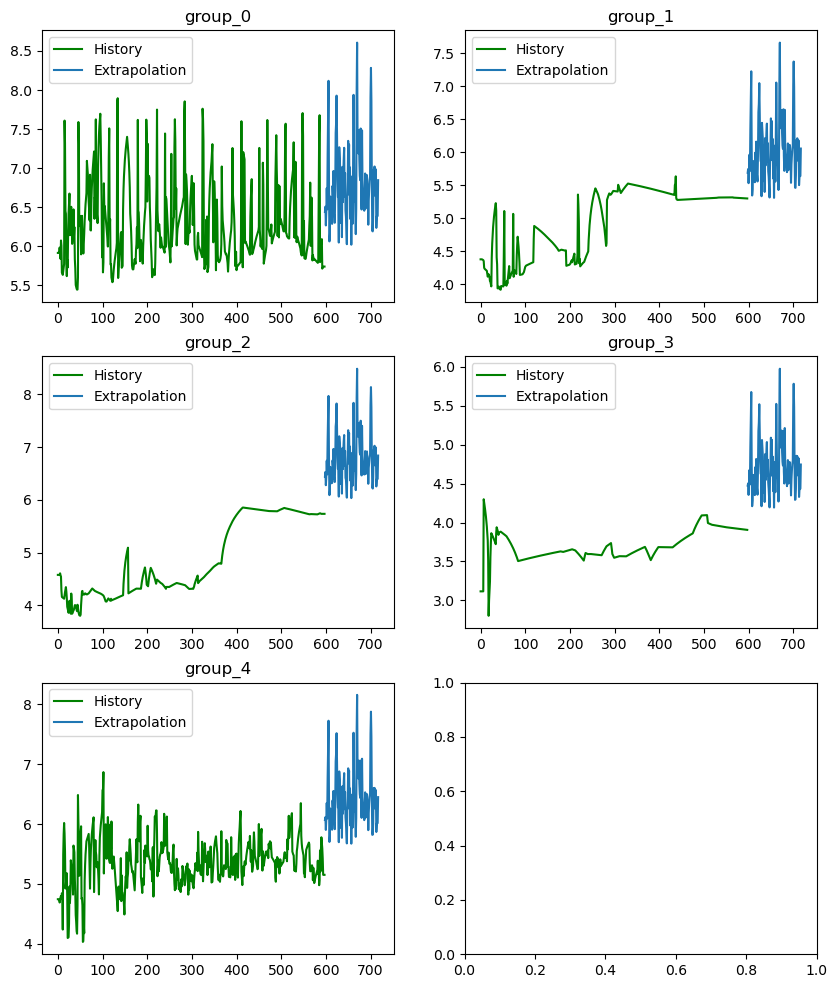

In [ ]:
# abiotic_data = pd.read_csv("DANTZGT_abio_extrapolate_48.csv")
print(test_data.shape)
abiotic_data = test_data[abio_columns]

print(abiotic_data.shape)
print(abiotic_data.head())

phytoplankton_history = location_data_dict["DANTZGT"][group_labels]
print(phytoplankton_history.head())

extrapolated_data, test = extrapolate(model, abiotic_data, phytoplankton_history, device)

colcount = 2

rowcount = int(math.ceil(len(group_labels) / colcount))

fig, ax = plt.subplots(rowcount, colcount, 
                figsize=(5 * colcount, 4 * rowcount))

for i, column in enumerate(group_labels):

    extrapolated_column = extrapolated_data[:, i]

    if colcount == 1:
        subplot = ax[i // colcount]
    else:
        subplot = ax[i // colcount][i % colcount]
    
    hist_length = len(phytoplankton_history[column])

    subplot.plot(range(hist_length), phytoplankton_history[column], 'g', label="History")

    subplot.plot(range(hist_length, hist_length + len(extrapolated_column)), extrapolated_column, label="Extrapolation")
    subplot.legend()
    subplot.set_title(column)